In [1]:
%load_ext autoreload
%autoreload 2

#### Imports

###### Global Imports

In [2]:
import sys
import warnings
from pprint import pprint

sys.path.append(r"../")
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import databricks.koalas as ks

import hvplot
import panel as pn
import holoviews as hv
pn.extension('bokeh')

import dp
import eda
import utils
import features
import model_gen
import model_eval

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql import types as DT
from pyspark.sql import functions as F

from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, OneHotEncoderEstimator, Imputer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.mllib.evaluation import RegressionMetrics

In [5]:
spark = SparkSession.builder.getOrCreate()

### Data Read

In [6]:
%%time
data = dp.read_data(spark=spark, 
                    path="/FileStore/tables/sales_data_sample.csv", 
                    fs="dbfs", 
                    fmt="csv", 
                    header="true", 
                    inferschema="true")
data.printSchema()

root
 |-- CHANNEL_REPORTING: string (nullable = true)
 |-- GLDate: string (nullable = true)
 |-- InvoiceNumber: integer (nullable = true)
 |-- Customername: string (nullable = true)
 |-- Orderno: integer (nullable = true)
 |-- OrderType: string (nullable = true)
 |-- SalesPerson: string (nullable = true)
 |-- InvtID: string (nullable = true)
 |-- SKuDescription: string (nullable = true)
 |-- BusinessUnit: integer (nullable = true)
 |-- Line: integer (nullable = true)
 |-- ManufSRP2: string (nullable = true)
 |-- Platforms: string (nullable = true)
 |-- Carrier: string (nullable = true)
 |-- LocOrUnLoc: string (nullable = true)
 |-- QtyShipped: integer (nullable = true)
 |-- UnitCost: double (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- ExtPrice: double (nullable = true)
 |-- ExtCost: double (nullable = true)
 |-- GP: double (nullable = true)
 |-- ModelFamily: string (nullable = true)
 |-- StockCondition: string (nullable = true)
 |-- color: string (nullable = true)
 |

In [7]:
target_col = 'UnitPrice'

In [8]:
data.count()

174813

In [9]:
data.show(n=1,vertical=True)

-RECORD 0---------------------------------
 CHANNEL_REPORTING | APPLE GIVEBACK       
 GLDate            | 04/11/2019           
 InvoiceNumber     | 54746876             
 Customername      | AUC Zhongxing int... 
 Orderno           | 31336494             
 OrderType         | SO                   
 SalesPerson       | LMO                  
 InvtID            | IPMI464G-000-WF14G40 
 SKuDescription    | APL IPDM4 GLD 64G... 
 BusinessUnit      | 6219900              
 Line              | 30000                
 ManufSRP2         | APL                  
 Platforms         | A1538                
 Carrier           | 0                    
 LocOrUnLoc        | ULD                  
 QtyShipped        | 3                    
 UnitCost          | 91.304               
 UnitPrice         | 95.0                 
 ExtPrice          | 285.0                
 ExtCost           | 273.91               
 GP                | 11.09                
 ModelFamily       | MIN464               
 StockCondi

1. BusinessUnit are the place where products are manufactured
2. Line is the Shipment line

So converting numbers to string

GLDate is datetime column

In [10]:
data = data.withColumn("BusinessUnit", data["BusinessUnit"].cast("string"))
data = data.withColumn("Line", data["Line"].cast("string"))
# data = data.withColumn("GLDate", data["GLDate"].cast("date"))  # throwing error in further analysis

#### Identification of columns types in the data

In [11]:
%%time
num_cols = dp._list_numerical_columns(spark, data)
cat_cols = dp._list_categorical_columns(spark, data)   
bool_cols = dp._list_boolean_columns(spark, data)
date_cols = dp._list_datelike_columns(spark, data)
pprint({"Numerical cols":num_cols, "Categorical cols":cat_cols, 
        "Boolean cols":bool_cols,"Datetime cols" :date_cols})

{'Boolean cols': [],
 'Categorical cols': ['CHANNEL_REPORTING',
                      'GLDate',
                      'Customername',
                      'OrderType',
                      'SalesPerson',
                      'InvtID',
                      'SKuDescription',
                      'BusinessUnit',
                      'Line',
                      'ManufSRP2',
                      'Platforms',
                      'Carrier',
                      'LocOrUnLoc',
                      'ModelFamily',
                      'StockCondition',
                      'color',
                      'MemorySize',
                      'Technology',
                      'RS_Color',
                      'RS_ModelFamily',
                      'RS_Grade',
                      'FunctionalStatus',
                      'RS_memorySize',
                      'RS_Brand',
                      'MDM_SourceChannel'],
 'Datetime cols': [],
 'Numerical cols': ['InvoiceNumber',
         

In [12]:
data = data.replace({'':None}, subset=cat_cols)
data = data.replace({'NULL':None}, subset=cat_cols)
data = data.replace({'NA ':None}, subset=cat_cols)
data = data.replace({'NA':None}, subset=cat_cols)

## EDA

### Health Analysis

In [13]:
health_plot=eda.plot_health(spark,data)

In [14]:
pn.panel(health_plot)

HoloViews(Layout)

### Missing data summary


In [15]:
# dp.identify_missing_values(spark,data)
missing_summary = eda.missing_value_summary(spark,data)

In [16]:
missing_summary

index     Variable Name  No of Missing  Percentage Missing
0     25        Technology          11150            6.378244
1     26          RS_Color            309            0.176760
2     27    RS_ModelFamily             87            0.049767
3     28          RS_Grade              1            0.000572
4     29  FunctionalStatus              1            0.000572
5     30     RS_memorySize          14006            8.011990
6     31          RS_Brand             28            0.016017

### Imputing Data

In [17]:
%%time
missing_cols = list(missing_summary["Variable Name"].values)
imputed_data = dp.handle_missing_values(spark, data, cols=missing_cols, rules={})

CPU times: user 46.9 ms, sys: 0 ns, total: 46.9 ms
Wall time: 21.4 s


In [18]:
eda.missing_value_summary(spark,imputed_data)

'No Missing Values'

In [19]:
# imputed_data.columns

In [41]:
columns_to_drop = ['GLDate', 'InvoiceNumber','Customername','Orderno']
imputed_data = imputed_data.drop(*columns_to_drop)

### Outlier Identification and Handling

In [21]:
%%time
print(imputed_data.count())
outlier_handled_data = dp.handle_outliers(spark, imputed_data, cols=[], drop=False, cap=True, method='iqr', iqr_multiplier=1.5)
print(outlier_handled_data.count())

174813
174813
CPU times: user 31.2 ms, sys: 62.5 ms, total: 93.8 ms
Wall time: 40.8 s


### Encoding Categorical Features

In [35]:
kdf = imputed_data.to_koalas()

In [39]:
_CatCol = dp._list_categorical_columns(spark, imputed_data)

In [40]:
kdf[_CatCol].nunique()

CHANNEL_REPORTING       12
OrderType                4
SalesPerson             16
InvtID               13852
SKuDescription       13549
BusinessUnit            18
Line                  1017
ManufSRP2               15
Platforms              210
Carrier                 15
LocOrUnLoc               3
ModelFamily            242
StockCondition          25
color                   38
MemorySize              12
Technology               5
RS_Color                37
RS_ModelFamily         135
RS_Grade                10
FunctionalStatus         3
RS_memorySize            7
RS_Brand                12
MDM_SourceChannel        5
Name: 0, dtype: int64

In [42]:
columns_to_drop = ['InvtID','SKuDescription','Line','ModelFamily','Platforms']
imputed_data = imputed_data.drop(*columns_to_drop)

In [43]:
%%time 
# by default onehot encoding is used.
encoded_data = features.encode_categorical_features(spark, imputed_data,cols=[],rules={})

CHANNEL_REPORTING {'method': 'onehot'}
OrderType {'method': 'onehot'}
SalesPerson {'method': 'onehot'}
BusinessUnit {'method': 'onehot'}
ManufSRP2 {'method': 'onehot'}
Carrier {'method': 'onehot'}
LocOrUnLoc {'method': 'onehot'}
StockCondition {'method': 'onehot'}
color {'method': 'onehot'}
MemorySize {'method': 'onehot'}
Technology {'method': 'onehot'}
RS_Color {'method': 'onehot'}
RS_ModelFamily {'method': 'onehot'}
RS_Grade {'method': 'onehot'}
FunctionalStatus {'method': 'onehot'}
RS_memorySize {'method': 'onehot'}
RS_Brand {'method': 'onehot'}
MDM_SourceChannel {'method': 'onehot'}
CPU times: user 266 ms, sys: 93.8 ms, total: 359 ms
Wall time: 1min 41s


In [23]:
# # dropping columns with index 
# index_columns_to_drop = [x for x in encoded_data.columns if 'index' in x]
# encoded_data = encoded_data.drop(*index_columns_to_drop)

### Feature Selection

functions available `feature_elimination_by_sparseness`, `feature_elimination_by_cv` ,`feature_elimination_by_missing_values`
`feature_elimination_by_correlation` , `feature_elimination_by_mutual_value`, `feature_elimination_by_lasso`

In [44]:
features.feature_elimination_by_sparseness(spark,data,threshold=0.1)

[]

In [45]:
features.feature_elimination_by_cv(spark,data,threshold=0.1)

['InvoiceNumber', 'Orderno']

In [46]:
feat,missing_val_count = features.feature_elimination_by_missing_values(spark,data)
feat

[]

In [47]:
features.feature_elimination_by_correlation(spark,data,threshold=0.1,target=target_col)

['InvoiceNumber', 'Orderno', 'QtyShipped', 'GP']

In [48]:
# features.feature_elimination_by_mutual_value(spark,outlier_handled_data,threshold=0.1,target=target_col) # bug not working

In [49]:
features.feature_elimination_by_lasso(spark,data,target=target_col,target_type='continuous',alpha=1)

['InvoiceNumber', 'QtyShipped', 'ExtPrice', 'ExtCost']

#### Model DataPrep and Vector Generation

In [50]:
%%time
outlier_indicators = [x for x in encoded_data.columns if 'outlier' in x]
index_columns = [x for x in encoded_data.columns if 'index' in x]
num_cols_1 = dp._list_numerical_columns(spark, encoded_data)
cat_cols_1 = dp._list_categorical_columns(spark, encoded_data)   
bool_cols_1 = dp._list_boolean_columns(spark, encoded_data)
date_cols_1 = dp._list_datelike_columns(spark, encoded_data)
pprint({'Numerical cols':num_cols_1, 'Categorical cols':cat_cols_1,'Boolean cols' : bool_cols_1,'Datetime cols' :date_cols_1})

{'Boolean cols': [],
 'Categorical cols': ['CHANNEL_REPORTING',
                      'OrderType',
                      'SalesPerson',
                      'BusinessUnit',
                      'ManufSRP2',
                      'Carrier',
                      'LocOrUnLoc',
                      'StockCondition',
                      'color',
                      'MemorySize',
                      'Technology',
                      'RS_Color',
                      'RS_ModelFamily',
                      'RS_Grade',
                      'FunctionalStatus',
                      'RS_memorySize',
                      'RS_Brand',
                      'MDM_SourceChannel'],
 'Datetime cols': [],
 'Numerical cols': ['QtyShipped',
                    'UnitCost',
                    'UnitPrice',
                    'ExtPrice',
                    'ExtCost',
                    'GP',
                    'CHANNEL_REPORTING_index',
                    'onehot_encoded_CHANNEL_REPORTING',

In [51]:
feature_cols = encoded_data.columns
feature_cols.remove(target_col)
feature_cols = [x for x in feature_cols if x not in index_columns]
feature_cols = [x for x in feature_cols if x not in outlier_indicators]
feature_cols = [x for x in feature_cols if x not in cat_cols_1]
feature_cols = [x for x in feature_cols if x not in date_cols_1]
feature_cols

['QtyShipped',
 'UnitCost',
 'ExtPrice',
 'ExtCost',
 'GP',
 'onehot_encoded_CHANNEL_REPORTING',
 'onehot_encoded_OrderType',
 'onehot_encoded_SalesPerson',
 'onehot_encoded_BusinessUnit',
 'onehot_encoded_ManufSRP2',
 'onehot_encoded_Carrier',
 'onehot_encoded_LocOrUnLoc',
 'onehot_encoded_StockCondition',
 'onehot_encoded_color',
 'onehot_encoded_MemorySize',
 'onehot_encoded_Technology',
 'onehot_encoded_RS_Color',
 'onehot_encoded_RS_ModelFamily',
 'onehot_encoded_RS_Grade',
 'onehot_encoded_FunctionalStatus',
 'onehot_encoded_RS_memorySize',
 'onehot_encoded_RS_Brand',
 'onehot_encoded_MDM_SourceChannel']

In [52]:
%%time
model_data = dp.generate_features_vector(spark, encoded_data, feature_cols, output_col="modeled_features")

CPU times: user 15.6 ms, sys: 0 ns, total: 15.6 ms
Wall time: 26 ms


In [53]:
print(model_data.columns)

['CHANNEL_REPORTING', 'OrderType', 'SalesPerson', 'BusinessUnit', 'ManufSRP2', 'Carrier', 'LocOrUnLoc', 'QtyShipped', 'UnitCost', 'UnitPrice', 'ExtPrice', 'ExtCost', 'GP', 'StockCondition', 'color', 'MemorySize', 'Technology', 'RS_Color', 'RS_ModelFamily', 'RS_Grade', 'FunctionalStatus', 'RS_memorySize', 'RS_Brand', 'MDM_SourceChannel', 'CHANNEL_REPORTING_index', 'onehot_encoded_CHANNEL_REPORTING', 'OrderType_index', 'onehot_encoded_OrderType', 'SalesPerson_index', 'onehot_encoded_SalesPerson', 'BusinessUnit_index', 'onehot_encoded_BusinessUnit', 'ManufSRP2_index', 'onehot_encoded_ManufSRP2', 'Carrier_index', 'onehot_encoded_Carrier', 'LocOrUnLoc_index', 'onehot_encoded_LocOrUnLoc', 'StockCondition_index', 'onehot_encoded_StockCondition', 'color_index', 'onehot_encoded_color', 'MemorySize_index', 'onehot_encoded_MemorySize', 'Technology_index', 'onehot_encoded_Technology', 'RS_Color_index', 'onehot_encoded_RS_Color', 'RS_ModelFamily_index', 'onehot_encoded_RS_ModelFamily', 'RS_Grade_in

`Observe new column 'modeled_features' is created.`

#### Scaling 

In [54]:
scaled_data = features.scale_data(spark,model_data,column='modeled_features',method='standard',prefix='scaled_') # other option is method = 'min_max'

In [55]:
print(scaled_data.columns)

['CHANNEL_REPORTING', 'OrderType', 'SalesPerson', 'BusinessUnit', 'ManufSRP2', 'Carrier', 'LocOrUnLoc', 'QtyShipped', 'UnitCost', 'UnitPrice', 'ExtPrice', 'ExtCost', 'GP', 'StockCondition', 'color', 'MemorySize', 'Technology', 'RS_Color', 'RS_ModelFamily', 'RS_Grade', 'FunctionalStatus', 'RS_memorySize', 'RS_Brand', 'MDM_SourceChannel', 'CHANNEL_REPORTING_index', 'onehot_encoded_CHANNEL_REPORTING', 'OrderType_index', 'onehot_encoded_OrderType', 'SalesPerson_index', 'onehot_encoded_SalesPerson', 'BusinessUnit_index', 'onehot_encoded_BusinessUnit', 'ManufSRP2_index', 'onehot_encoded_ManufSRP2', 'Carrier_index', 'onehot_encoded_Carrier', 'LocOrUnLoc_index', 'onehot_encoded_LocOrUnLoc', 'StockCondition_index', 'onehot_encoded_StockCondition', 'color_index', 'onehot_encoded_color', 'MemorySize_index', 'onehot_encoded_MemorySize', 'Technology_index', 'onehot_encoded_Technology', 'RS_Color_index', 'onehot_encoded_RS_Color', 'RS_ModelFamily_index', 'onehot_encoded_RS_ModelFamily', 'RS_Grade_in

`Observe new column 'scaled_modeled_features' is created`

#### Train Test Split

In [56]:
%%time
train_df, test_df = dp.test_train_split(spark, data=scaled_data, features_col="scaled_modeled_features", target_col=target_col, train_prop=0.7, random_seed=111)

CPU times: user 15.6 ms, sys: 0 ns, total: 15.6 ms
Wall time: 267 ms


In [57]:
print((train_df.count(), len(train_df.columns)))
print((test_df.count(), len(test_df.columns)))

(122262, 62) ['CHANNEL_REPORTING', 'OrderType', 'SalesPerson', 'BusinessUnit', 'ManufSRP2', 'Carrier', 'LocOrUnLoc', 'QtyShipped', 'UnitCost', 'y', 'ExtPrice', 'ExtCost', 'GP', 'StockCondition', 'color', 'MemorySize', 'Technology', 'RS_Color', 'RS_ModelFamily', 'RS_Grade', 'FunctionalStatus', 'RS_memorySize', 'RS_Brand', 'MDM_SourceChannel', 'CHANNEL_REPORTING_index', 'onehot_encoded_CHANNEL_REPORTING', 'OrderType_index', 'onehot_encoded_OrderType', 'SalesPerson_index', 'onehot_encoded_SalesPerson', 'BusinessUnit_index', 'onehot_encoded_BusinessUnit', 'ManufSRP2_index', 'onehot_encoded_ManufSRP2', 'Carrier_index', 'onehot_encoded_Carrier', 'LocOrUnLoc_index', 'onehot_encoded_LocOrUnLoc', 'StockCondition_index', 'onehot_encoded_StockCondition', 'color_index', 'onehot_encoded_color', 'MemorySize_index', 'onehot_encoded_MemorySize', 'Technology_index', 'onehot_encoded_Technology', 'RS_Color_index', 'onehot_encoded_RS_Color', 'RS_ModelFamily_index', 'onehot_encoded_RS_ModelFamily', 'RS_Gra

#### Model Train and Eval

In [58]:
model_gen.valid_model_types

['regression', 'classification']

In [59]:
pprint(model_gen.model_objects)

{'classification': {'decision_tree': {'estimator': 'pyspark.ml.classification.DecisionTreeClassifier',
                                      'model': 'pyspark.ml.classification.DecisionTreeClassifierModel'},
                    'gbt': {'estimator': 'pyspark.ml.classification.GBTClassifier',
                            'model': 'pyspark.ml.classification.GBTClassifierModel'},
                    'logistic': {'estimator': 'pyspark.ml.classification.LogisticRegression',
                                 'model': 'pyspark.ml.classification.LogisticRegressionModel'},
                    'multi_layer_perceptron': {'estimator': 'pyspark.ml.classification.MultilayerPerceptronClassifier',
                                               'model': 'pyspark.ml.classification.MultilayerPerceptronClassifierModel'},
                    'naive_bayes': {'estimator': 'pyspark.ml.classification.NaiveBayes',
                                    'model': 'pyspark.ml.classification.NaiveBayesModel'},
          

In [60]:
%%time
_model_str_ = 'linear_regression'
estimator = utils.load_class(model_gen.model_objects['regression'][_model_str_]['estimator'])
estimator

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 69.4 µs


pyspark.ml.regression.LinearRegression

In [61]:
%%time
_model_ = estimator(featuresCol="features", labelCol="y", predictionCol='yhat')
model = _model_.fit(train_df)
preds = model.transform(test_df)
print("Coefficients: " + str(model.coefficients))
print("Intercept: " + str(model.intercept))
preds.select("y","yhat").show(5)

Coefficients: [-0.49529048401670583,13.28612313288268,0.33940629263376754,0.24261706201420427,0.46647681096156995,0.030600453013093176,0.44485021150466153,-0.9586782659089872,0.5644496263591098,-0.7617331181894414,0.14377201883773416,0.11504343813535395,1.6392388118566146,0.13695297233510031,-0.05151962961339619,-0.08090176272220766,-1.8852720649549477,1.5071617757733395,0.11066681758973765,0.4500949211505354,1.9994337533609625,-1.1899183918944989,-3.71500647476651,-1.062126618235359,-1.1252746979331372,1.211401665438717,2.848748244582182,4.177807457458854,-0.601337912556029,-1.1691731139049808,-0.2512442618496257,-0.18746696191533097,0.4132637476083789,-0.2260784496944517,1.0433987130089477,3.710337889809102,1.4941838891269172,-5.673064312275985,0.3681201940919109,0.6311530274185154,-6.45840811169831,0.9305934030223065,-0.6409569801471545,0.8898972596942976,0.3552763679234151,-0.24906888438721247,-0.13324993234425933,-0.511598508507116,0.1957626562885304,0.4633627057108846,0.091067195

#### Model Evaluation Metrics

In [62]:
%%time
reg_metrics = model_eval.get_regression_metrics(spark, data=preds, y_col='y' , y_pred_cols=['yhat'])
reg_metrics.show()

+------------------+-------------------+
|            metric|               yhat|
+------------------+-------------------+
|Explained Variance|0.04828418010920443|
|              RMSE|  24.89441428545234|
|               MAE| 15.550517986804959|
|               MSE|  619.7318626157335|
|              MAPE|0.19031697739190537|
|             WMAPE|0.11489706932376503|
|              R.Sq| 0.9517158193823517|
+------------------+-------------------+

CPU times: user 46.9 ms, sys: 31.2 ms, total: 78.1 ms
Wall time: 2min 41s


#### Regression Plots

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


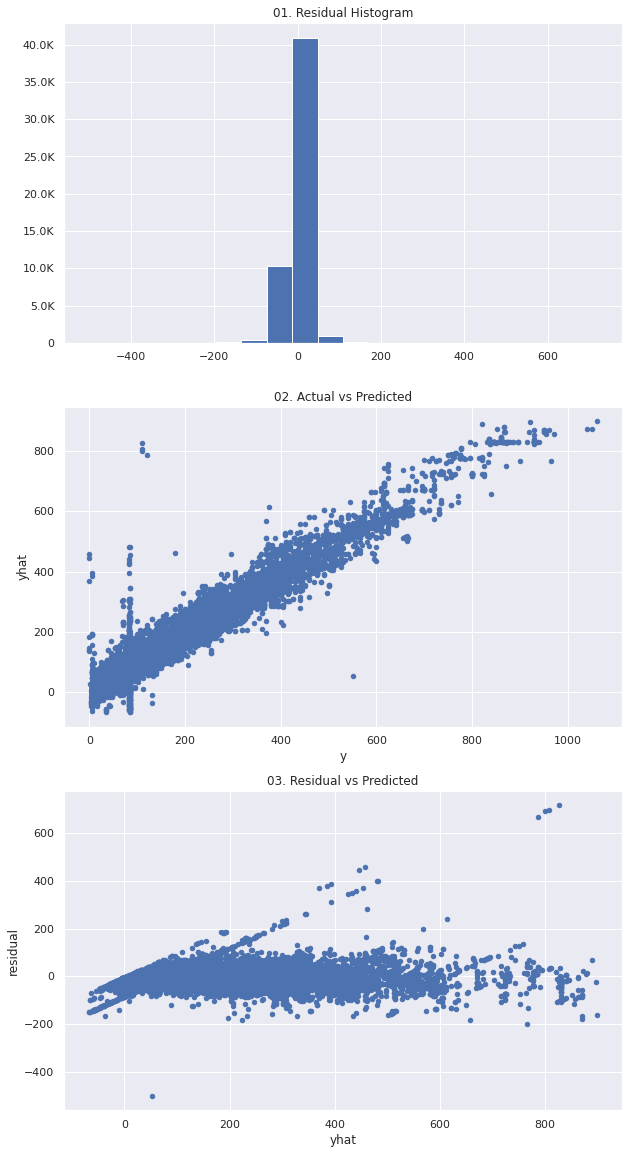

CPU times: user 688 ms, sys: 125 ms, total: 812 ms
Wall time: 2min 16s


In [63]:
%%time
model_eval.generate_regression_plots(spark, preds, 'y', 'yhat')